# SEEP DETECTION (IMAGE SEGMENTATION)

## Name : - Yash Desai

## Email    : - datasc.yash@gmail.com 

# Importing Necessary Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import os
import glob
import tensorflow.keras as keras
import warnings
import numpy as np
import tensorflow as tf
import skimage.io as io
import keras.backend as K
from functools import partial
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from tensorflow.python.keras import losses
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator


Changing the current working directory

In [ ]:
cd /content/drive/MyDrive/cgg/seep_detection/

/content/drive/MyDrive/cgg/seep_detection


Setting the paths for our train_images and train_masks

In [ ]:
train_paths = sorted(glob.glob('train_images_256/*'))
mask_paths = sorted(glob.glob('train_masks_256/*'))

In [ ]:
len(train_paths),len(mask_paths)

(790, 790)

# Making Utility Functions


Functions to pre_process images and create our dataset (images,masks) 

In [ ]:
def image_thresh(image):
  image = image/255
  return image

def mask_thresh(mask):
  ret, mask = cv2.threshold(mask, 0 ,1, cv2.THRESH_BINARY)
  return mask

def create_data(image_path, mask_path):
  X = []
  y = []
  for im in image_path:
    x = cv2.cvtColor(cv2.imread(im), cv2.COLOR_BGR2RGB)
    X.append(image_thresh(x))
  for m in mask_path:
    mask = io.imread(m)
    mask = mask_thresh(mask)
    mask = mask.reshape([256, 256, 1])
    y.append(mask)
  return np.array(X),np.array(y)

# Visualising our images and masks

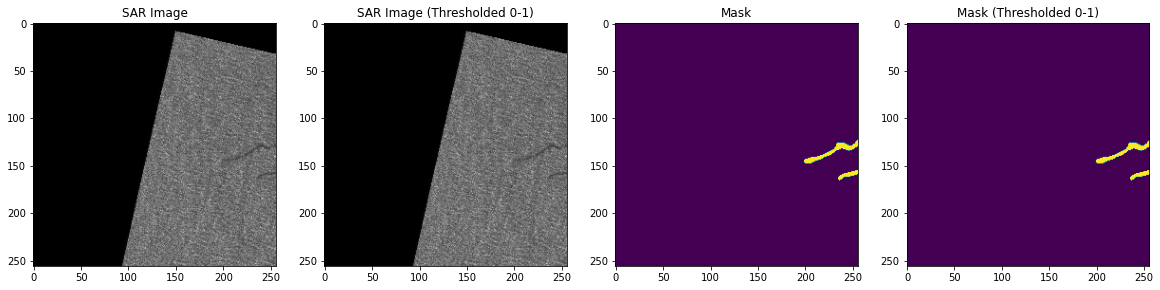

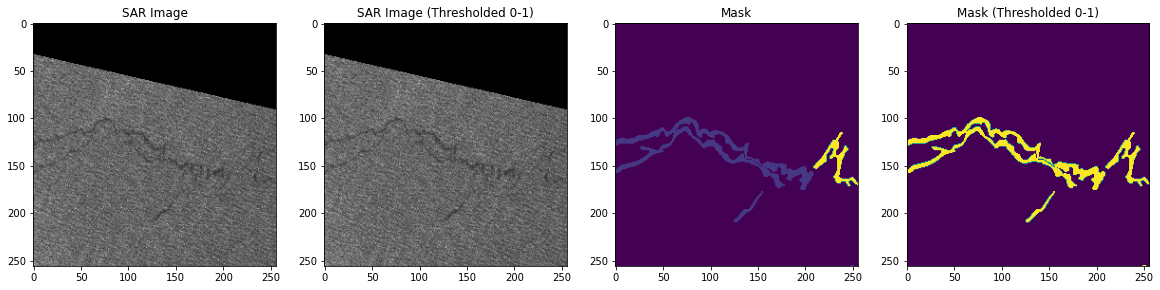

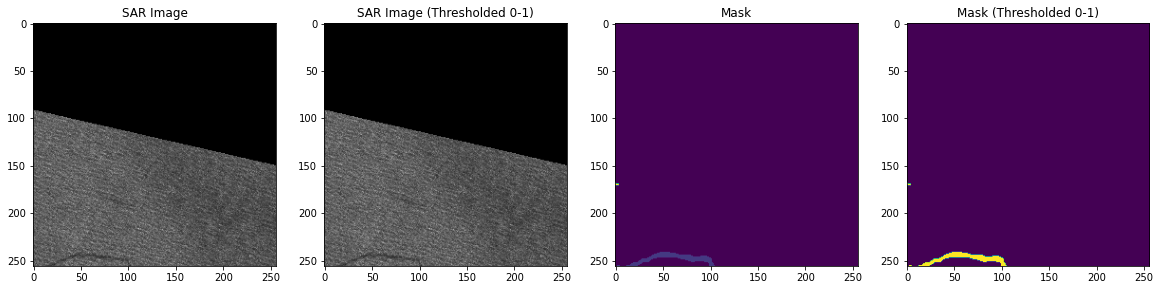

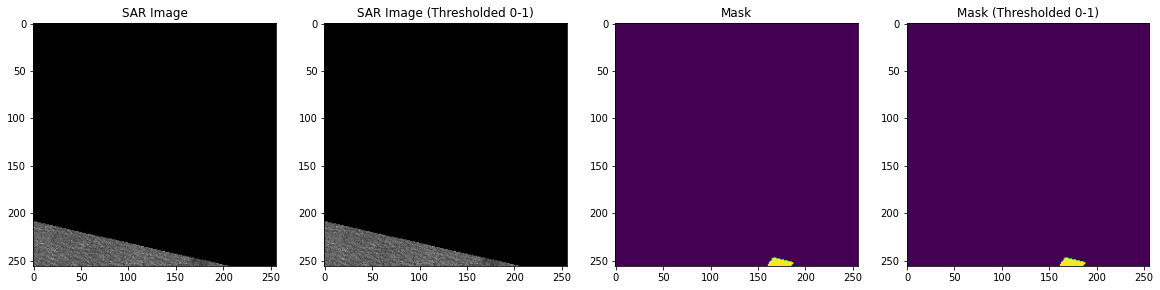

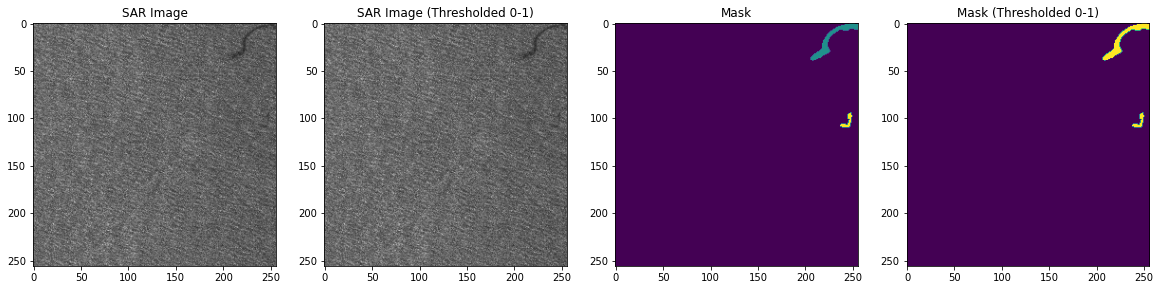

In [ ]:
n = range(5)
for i in n:
  figure,ax = plt.subplots(1,4,figsize=(20,20))
  x = cv2.cvtColor(cv2.imread(train_paths[i]), cv2.COLOR_BGR2RGB)
  y = io.imread(mask_paths[i])
  x_th = image_thresh(x)
  y_th = mask_thresh(y)

  ax[0].imshow(x)
  ax[1].imshow(x_th)
  ax[2].imshow(y)
  ax[3].imshow(y_th)

  ax[0].set_title("SAR Image")
  ax[1].set_title("SAR Image (Thresholded 0-1)")
  ax[2].set_title("Mask")
  ax[3].set_title("Mask (Thresholded 0-1)")

# Creating training and testing data

In [ ]:
X, y = create_data(train_paths,mask_paths)

In [ ]:
y = y.astype(np.float64)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Performing Image Augmentation using the ImageDataGenerator from keras. This will apply transformations to our data in real time while training. Transformations: - (rotate, zoom, horizontal flip etc.)

In [ ]:
from distutils import version
aug = ImageDataGenerator(rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     horizontal_flip=True,
                     fill_mode='constant',
                     cval=0,)

Checking the minimum and maximum values of all our data variables to ensure we have done correct pre-procesing

In [ ]:
print('Minimum Value --> X_train = {} , X_test = {} , y_train = {} , y_test = {} '.format(X_train[0].min(axis=(0,1,2)).round(2), X_test[0].min(axis=(0,1,2)).round(2), y_train[0].min(axis=(0,1,2)), y_test[0].min(axis=(0,1,2))))
print('Maximum Value --> X_train = {} , X_test = {} , y_train = {} , y_test = {} '.format(X_train[0].max(axis=(0,1,2)).round(2), X_test[0].max(axis=(0,1,2)).round(2), y_train[0].max(axis=(0,1,2)), y_test[0].max(axis=(0,1,2))))

Minimum Value --> X_train = 0.0 , X_test = 0.22 , y_train = 0.0 , y_test = 0.0 
Maximum Value --> X_train = 0.77 , X_test = 1.0 , y_train = 1.0 , y_test = 1.0 


while plotting the masks we use np.squeeze(masks) to get the dimensions back to (256,256) from (256,256,1)

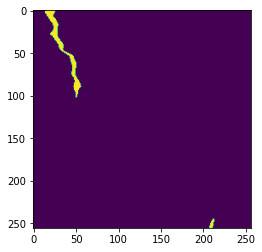

In [ ]:
plt.imshow(np.squeeze(y_train[8]))

# Creating a UNET model for performing segmentation


UNET:- It is a Deep Convolutional Neural Network. The network is based on a fully convolutional network whose architecture was modified and extended to work with fewer training images and yield more precise segmentation. 
It performs classification on every pixel so that the input and output share the same size. UNet is able to do image localisation by predicting the image pixel by pixel which is exactly what the problem statement demands.The model would make prediction on every pixels, resulting in the detection of oil seeps from SAR images in our case

For this image segmentation task I followed an encoder/decoder structure where we downsample the spatial resolution of the input, developing lower-resolution feature mappings which are learned to be highly efficient at discriminating between classes, and the upsample the feature representations into a full-resolution segmentation map.

In DCNN the earlier layers tend to learn low-level features while later layers develop more high-level feature mappings.Hence the need to upsample.

In [ ]:
def get_unet(hidden_activation='relu', initializer='he_normal', output_activation='sigmoid'):
  
  PartialConv = partial(keras.layers.Conv2D,activation=hidden_activation,kernel_initializer=initializer,padding='same')
  # Encoder
  model_input = keras.layers.Input(shape=(None, None, 3))
  enc_cov_1 = PartialConv(32, 3)(model_input)
  enc_cov_1 = PartialConv(32, 3)(enc_cov_1)
  enc_pool_1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(enc_cov_1)
  enc_cov_2 = PartialConv(64, 3)(enc_pool_1)
  enc_cov_2 = PartialConv(64, 3)(enc_cov_2)
  enc_pool_2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(enc_cov_2)
    
  enc_cov_3 = PartialConv(128, 3)(enc_pool_2)
  enc_cov_3 = PartialConv(128, 3)(enc_cov_3)
  enc_pool_3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(enc_cov_3)
    
  # Center
  center_cov = PartialConv(256, 3)(enc_pool_3)
  center_cov = PartialConv(256, 3)(center_cov)
    
  # Decoder
  upsampling1 = keras.layers.UpSampling2D(size=(2, 2))(center_cov)
  dec_up_conv_1 = PartialConv(128, 2)(upsampling1)
  dec_merged_1 = tf.keras.layers.Concatenate(axis=3)([enc_cov_3, dec_up_conv_1])
  dec_conv_1 = PartialConv(128, 3)(dec_merged_1)
  dec_conv_1 = PartialConv(128, 3)(dec_conv_1)
    
  upsampling2 = keras.layers.UpSampling2D(size=(2, 2))(dec_conv_1)
  dec_up_conv_2 = PartialConv(64, 2)(upsampling2)
  dec_merged_2 = tf.keras.layers.Concatenate(axis=3)([enc_cov_2, dec_up_conv_2])
  dec_conv_2 = PartialConv(64, 3)(dec_merged_2)
  dec_conv_2 = PartialConv(64, 3)(dec_conv_2)
    
  upsampling3 = keras.layers.UpSampling2D(size=(2, 2))(dec_conv_2)
  dec_up_conv_3 = PartialConv(32, 2)(upsampling3)
  dec_merged_3 = tf.keras.layers.Concatenate(axis=3)([enc_cov_1, dec_up_conv_3])
  dec_conv_3 = PartialConv(32, 3)(dec_merged_3)
  dec_conv_3 =  PartialConv(32, 3)(dec_conv_3)

  output = keras.layers.Conv2D(1, 1, activation=output_activation)(dec_conv_3)
  return tf.keras.Model(inputs=model_input, outputs=output)

In [ ]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

def get_iou(X, Y): 
    batch_size = X.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = X[batch], Y[batch]
        true = np.sum(t)
        pred = np.sum(p)

        if true == 0:
            metric += (pred == 0)
            continue
            
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union

        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        metric += iou

    metric /= batch_size
    return metric

def iou_score(label, pred):
    return tf.numpy_function(get_iou, [label, pred > 0.5], tf.float64)


In [ ]:
model = get_unet()
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer = optimizer, loss = bce_dice_loss , metrics = ['accuracy',iou_score,dice_coeff])
model.summary()
warnings.filterwarnings('ignore')

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_209 (Conv2D)            (None, None, None,   896         ['input_15[0][0]']               
                                32)                                                               
                                                                                                  
 conv2d_210 (Conv2D)            (None, None, None,   9248        ['conv2d_209[0][0]']             
                                32)                                                         

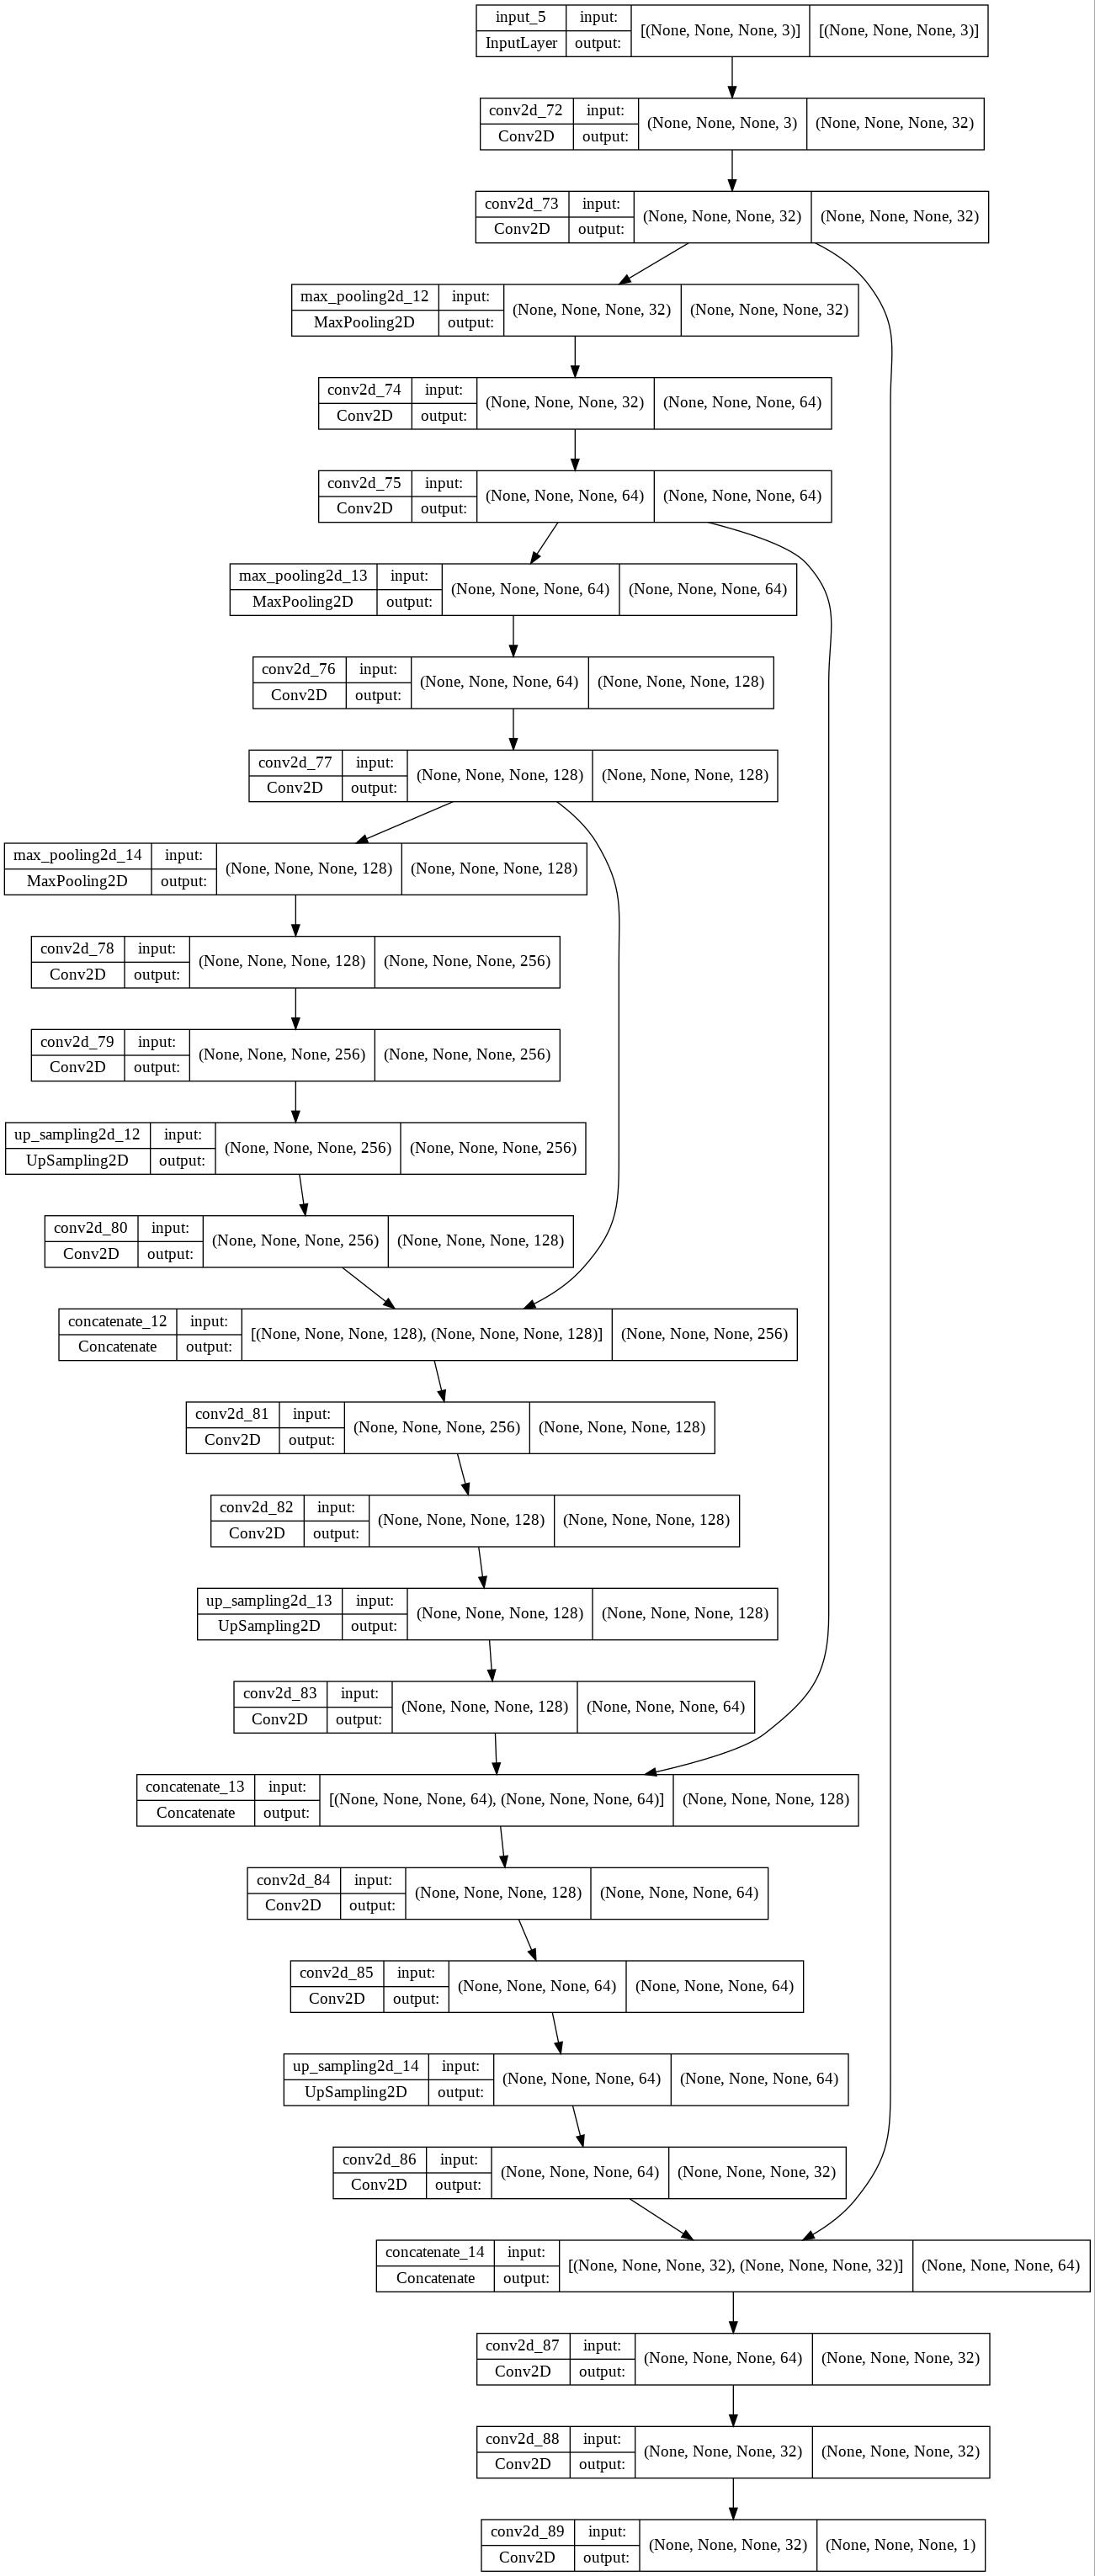

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.jpg', show_shapes=True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau
EarlyStop = EarlyStopping(patience = 10, restore_best_weights = True)
Reduce_LR = ReduceLROnPlateau(monitor = 'val_accuracy', verbose = 2, factor = 0.5, min_lr = 0.00001)
callback = [EarlyStop , Reduce_LR]

# Training the unet model

In [ ]:
history = model.fit_generator(
    aug.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=50, verbose=1, callbacks = callback
)

Epoch 1/50
20/20 [==============================] - 11s 460ms/step - loss: 1.1356 - accuracy: 0.9735 - iou_score: 0.0031 - dice_coeff: 0.0288 - val_loss: 1.0429 - val_accuracy: 0.9800 - val_iou_score: 0.0000e+00 - val_dice_coeff: 0.0493 - lr: 0.0010
Epoch 2/50
20/20 [==============================] - 9s 434ms/step - loss: 1.0637 - accuracy: 0.9824 - iou_score: 0.0031 - dice_coeff: 0.0313 - val_loss: 1.0468 - val_accuracy: 0.9800 - val_iou_score: 0.0000e+00 - val_dice_coeff: 0.0432 - lr: 0.0010
Epoch 3/50
20/20 [==============================] - 9s 446ms/step - loss: 1.0604 - accuracy: 0.9824 - iou_score: 0.0031 - dice_coeff: 0.0302 - val_loss: 1.0392 - val_accuracy: 0.9800 - val_iou_score: 0.0000e+00 - val_dice_coeff: 0.0488 - lr: 0.0010
Epoch 4/50
20/20 [==============================] - 9s 441ms/step - loss: 1.0597 - accuracy: 0.9824 - iou_score: 0.0031 - dice_coeff: 0.0303 - val_loss: 1.0391 - val_accuracy: 0.9800 - val_iou_score: 0.0000e+00 - val_dice_coeff: 0.0495 - lr: 0.0010
Epo

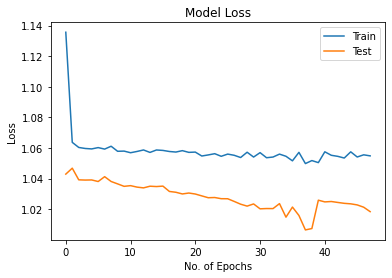

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('No. of Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [ ]:
model.save("model.h5")

In [ ]:
model.load_weights('model.h5')

In [ ]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 1s 121ms/step - loss: 1.0065 - accuracy: 0.9800 - iou_score: 0.0000e+00 - dice_coeff: 0.0865


[1.0064921379089355, 0.9800282716751099, 0.0, 0.08648844063282013]

## Evaluation Metrics Used

1. Dice Loss:- 

    The loss function used for our image segmentation task is based on the Dice coefficient, which is essentially a measure of overlap between two samples. This measure ranges from 0 to 1 where a Dice coefficient of 1 denotes perfect and complete overlap.

2. Dice Coefficient

3. IOU:- 
    The Intersection over Union metric (Jaccard index) is essentially a method to quantify the percent overlap between the target mask and our prediction output.



4. Accuracy

# Visualising Predictions

In [ ]:
predictions = model.predict(X_test)

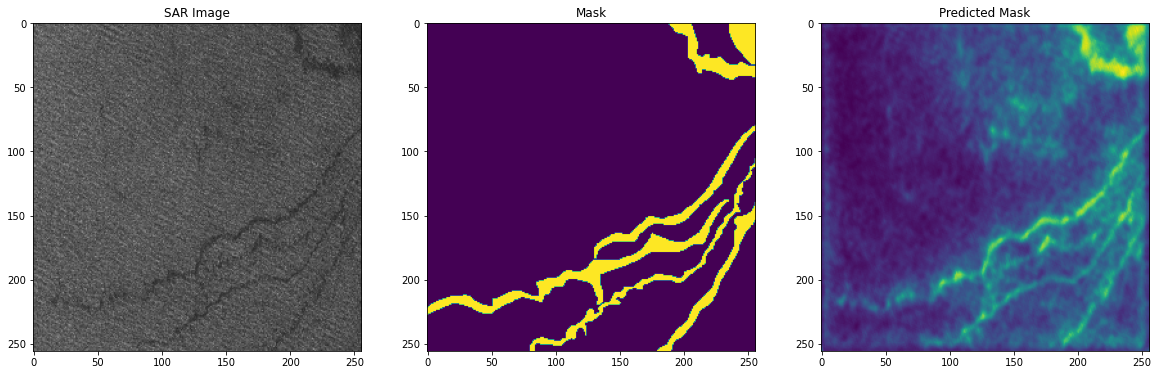

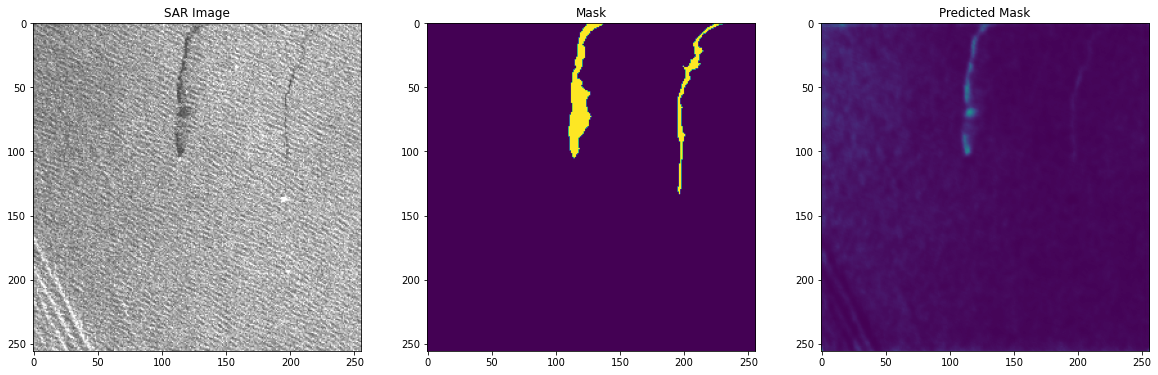

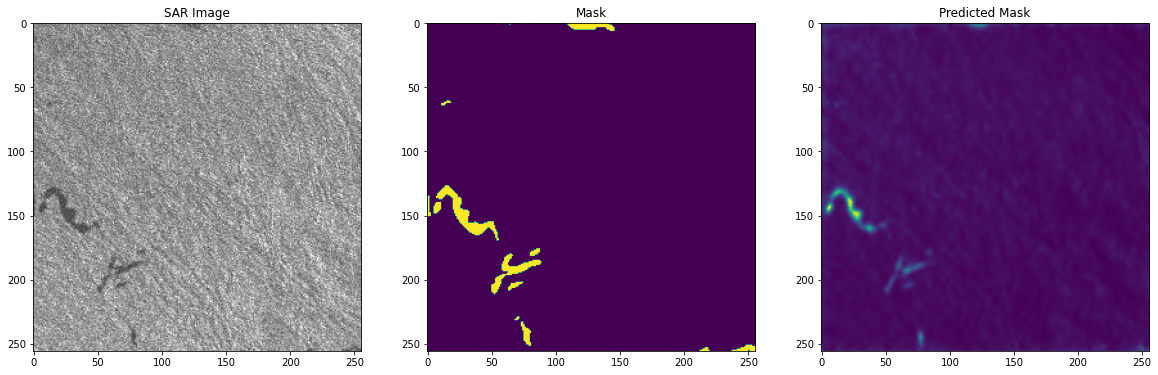

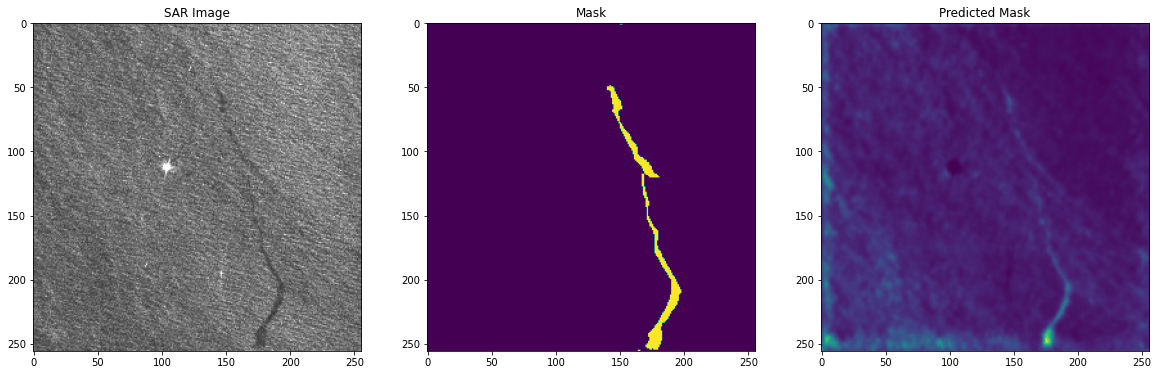

In [ ]:
n = range(7,11)
for i in n:
  figure,ax = plt.subplots(1,3,figsize=(20,20))

  ax[0].imshow(X_test[i])
  ax[1].imshow(np.squeeze(y_test[i]))
  ax[2].imshow(np.squeeze(predictions[i]))

  ax[0].set_title("SAR Image")
  ax[1].set_title("Mask")
  ax[2].set_title("Predicted Mask")

It can be seen that the model is able to capture the seeps from the SAR images, not exactly like the masks, but decent at some extent.